In [1]:
import numpy as np
import matplotlib as plt
import xarray as xr
import netCDF4

In [7]:
#Load in observations and model data
models=xr.open_dataset("/g/data/eg3/jp0715/HydroProj/data/hydroproj/gcm/spatial/nrms/annual/ensemble_members_combined/tasmin_historical_1976-2005_AU_spatial_ensemble_members.nc")
obs=xr.open_dataset("/g/data/eg3/jp0715/HydroProj/data/hydroproj/awap/spatial/nrms/annual/tasmin_AWAP_1976-2005_AU_spatial_stats.nc")
#Rerrange index of observation latitudes so it matches model data (necessary?)
obs_adjusted=obs.reindex(lat=list(reversed(obs.lat)))
#Subdivide model dataset into bias corrected and gdd data
models_bc=models.sel(bc_method=["isimip","mrnbc","qme"])
ccam_bc=models.sel(bc_method="ccam-isimip")
models_gdd=models.sel(bc_method="nobc")
ccam_gdd=models.sel(bc_method="nobc-ccam")
#Create empty datasets for added value calculations
Added_Value=xr.Dataset()
avs_initial=xr.Dataset()
avs_transition=xr.Dataset()
#Convert datasets to data-arrays so variables can be extracted (better way?)
new_models_gdd=models_gdd.to_array()
new_models_bc=models_bc.to_array()
new_obs=obs_adjusted.to_array()
new_ccam_bc=ccam_bc.to_array()
new_ccam_gdd=ccam_gdd.to_array()

#Obtain arrays of the bias corrections, models and variables
coords_bc=new_models_bc.coords["bc_method"].values
coords_model=new_models_bc.coords["model"].values
variables=new_models_bc.coords["variable"].values
#Determine number of each bc method, model and statistics/quantiles
variable_number=len(variables)
model_number=len(coords_model)
bc_number=len(coords_bc)

#Iterate the AV formula over every non-CCAM model, bc_method and variable
for h in range(variable_number):
    for i in range(model_number):
        for j in range(bc_number):
            av_lhs=np.abs(new_models_gdd.isel(variable=h,model=i)-new_obs.isel(variable=h))
            av_rhs=np.abs(new_models_bc.isel(variable=h,model=i,bc_method=j)-new_obs.isel(variable=h))
            av=av_lhs-av_rhs
            avs_initial[str(coords_bc[j])]=av
    #Loop CCAM data separately as it has different GDD data
        av_lhs=np.abs(new_ccam_gdd.isel(variable=h,model=i)-new_obs.isel(variable=h))
        av_rhs=np.abs(new_ccam_bc.isel(variable=h,model=i)-new_obs.isel(variable=h))
        av=av_lhs-av_rhs
        avs_initial["ccam-isimip"]=av
        #Shunt the added values into another dataset to create an added dimension of bc_method
        #Is there a better way to do this?
        avs_initial=avs_initial.to_array()
        avs_initial=avs_initial.reset_coords(drop=True) #Ghost, dimensionless coordinates still seem to appear? So clear them 
        avs_initial=avs_initial.rename({"variable":"bc_method"}) #Converting to an array sets the old variables as a dimension called 'variable'
        avs_transition[str(coords_model[i])]=avs_initial
        avs_initial=xr.Dataset() #Empty dataset to allow the next iteration of added values to enter
    #Once again, shunt added values into another dataset to add the dimension of models
    avs_transition=avs_transition.to_array()
    avs_transition=avs_transition.rename({"variable":"model"})
    Added_Value["av_"+str(variables[h])]=avs_transition
    avs_transition=xr.Dataset()
Added_Value

<xarray.Dataset>
Dimensions:              (lat: 681, lon: 841, bc_method: 4, model: 4)
Coordinates:
  * lat                  (lat) float64 -44.0 -43.95 -43.9 ... -10.1 -10.05 -10.0
  * lon                  (lon) float64 112.0 112.0 112.1 ... 153.9 153.9 154.0
  * bc_method            (bc_method) <U11 'isimip' 'mrnbc' 'qme' 'ccam-isimip'
  * model                (model) <U21 'CNRM-CERFACS-CNRM-CM5' ... 'NOAA-GFDL-...
Data variables: (12/21)
    av_tasmin_q_0.00027  (model, bc_method, lat, lon) float64 nan nan ... nan
    av_tasmin_q_0.00055  (model, bc_method, lat, lon) float64 nan nan ... nan
    av_tasmin_q_0.00137  (model, bc_method, lat, lon) float64 nan nan ... nan
    av_tasmin_q_0.00274  (model, bc_method, lat, lon) float64 nan nan ... nan
    av_tasmin_q_0.01     (model, bc_method, lat, lon) float64 nan nan ... nan
    av_tasmin_q_0.05     (model, bc_method, lat, lon) float64 nan nan ... nan
    ...                   ...
    av_tasmin_q_0.99945  (model, bc_method, lat, lon) float64 nan nan ... nan
    av_tasmin_q_0.99973  (model, bc_method, lat, lon) float64 nan nan ... nan
    av_tasmin_mean       (model, bc_method, lat, lon) float64 nan nan ... nan
    av_tasmin_std        (model, bc_method, lat, lon) float64 nan nan ... nan
    av_tasmin_max        (model, bc_method, lat, lon) float64 nan nan ... nan
    av_tasmin_min        (model, bc_method, lat, lon) float64 nan nan ... nan

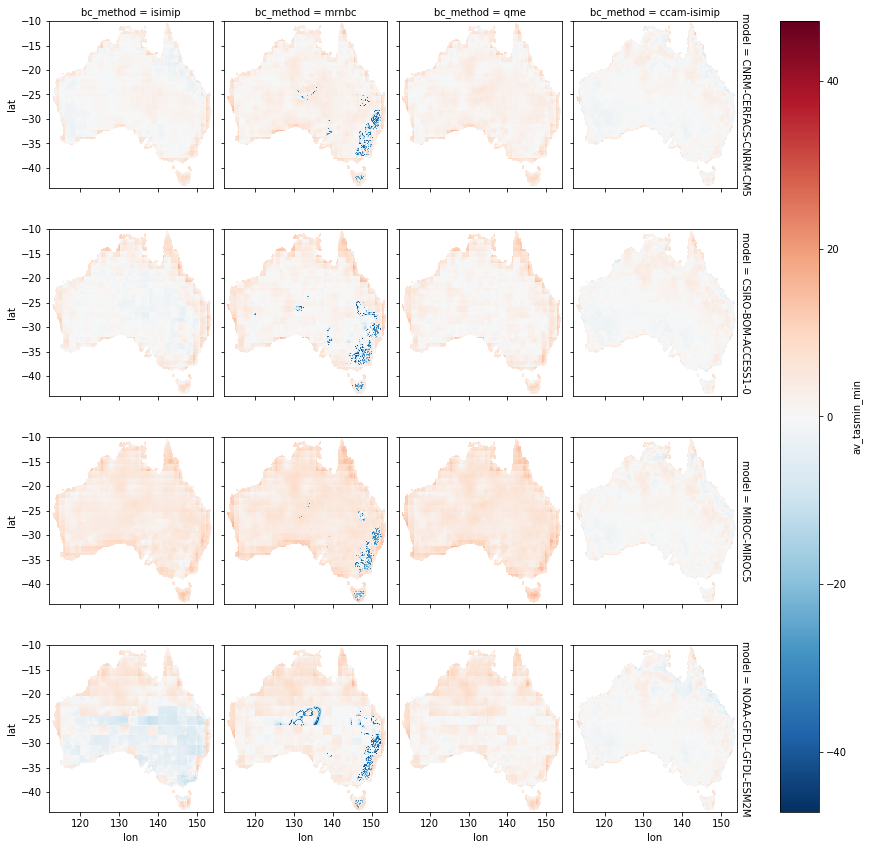

In [8]:
Added_Value["av_tasmin_min"].plot(row="model",col="bc_method")

In [11]:
#Percentage of gridsquares which have a positive AV for tasmin_min
Added_Value["av_tasmin_min"].where(Added_Value["av_tasmin_min"]>0).count(dim=["lat","lon"])/Added_Value["av_tasmin_min"].count(dim=["lat","lon"])*100

<xarray.DataArray 'av_tasmin_min' (model: 4, bc_method: 4)>
array([[66.03717314, 91.96321741, 93.78565976, 54.87138521],
       [58.86634358, 83.9310504 , 86.20226873, 60.64298521],
       [99.20115034, 96.51275497, 99.89490689, 63.90016155],
       [48.15572243, 81.54444267, 89.76904369, 56.77477765]])
Coordinates:
  * bc_method  (bc_method) <U11 'isimip' 'mrnbc' 'qme' 'ccam-isimip'
  * model      (model) <U21 'CNRM-CERFACS-CNRM-CM5' ... 'NOAA-GFDL-GFDL-ESM2M'

In [12]:
Added_Value["av_tasmin_min"].mean(dim=["lat","lon"])

<xarray.DataArray 'av_tasmin_min' (model: 4, bc_method: 4)>
array([[ 0.82657126,  1.57835684,  2.29544162,  0.3584266 ],
       [ 1.04381389,  1.21544388,  2.11632918,  0.62667896],
       [ 4.69026275,  4.71690642,  5.52332927,  0.63791653],
       [-0.14112792,  1.50434289,  2.92466862,  0.3071461 ]])
Coordinates:
  * bc_method  (bc_method) <U11 'isimip' 'mrnbc' 'qme' 'ccam-isimip'
  * model      (model) <U21 'CNRM-CERFACS-CNRM-CM5' ... 'NOAA-GFDL-GFDL-ESM2M'

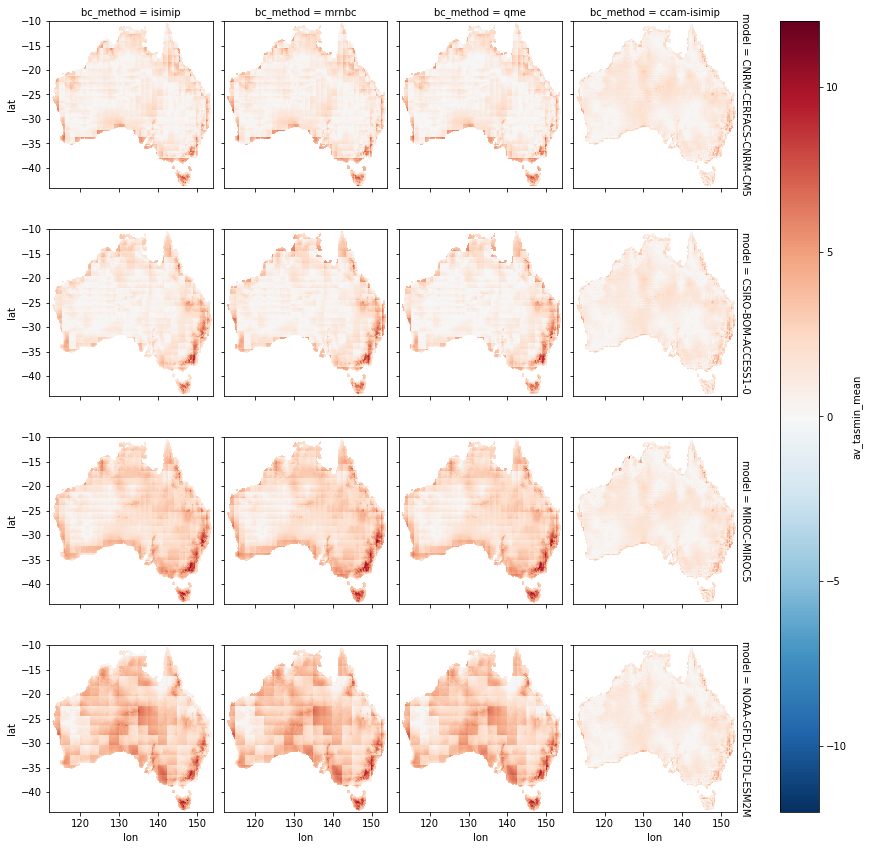

In [13]:
Added_Value["av_tasmin_mean"].plot(row="model",col="bc_method")

In [14]:
#Percentage of gridsquares which have a positive AV for tasmin_mean
Added_Value["av_tasmin_mean"].where(Added_Value["av_tasmin_mean"]>0).count(dim=["lat","lon"])/Added_Value["av_tasmin_mean"].count(dim=["lat","lon"])*100

<xarray.DataArray 'av_tasmin_mean' (model: 4, bc_method: 4)>
array([[99.66235288, 99.94283787, 95.04642204, 99.75927997],
       [99.75537448, 99.94354796, 94.39101028, 99.71631961],
       [99.89135645, 99.99467434, 99.23132911, 99.68614085],
       [99.67264916, 99.99396425, 98.28336085, 99.66767854]])
Coordinates:
  * bc_method  (bc_method) <U11 'isimip' 'mrnbc' 'qme' 'ccam-isimip'
  * model      (model) <U21 'CNRM-CERFACS-CNRM-CM5' ... 'NOAA-GFDL-GFDL-ESM2M'